<a href="https://colab.research.google.com/github/weibb123/Sentiment_analysis/blob/main/Sentiment_yelp_my_restuarant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers requests beautifulsoup4 pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 28.0 MB/s 
     |████████████████████████████████| 596 kB 59.6 MB/s 
     |████████████████████████████████| 6.6 MB 51.5 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Introduction


*   Procedure
*   Conclusion



In this notebook, we will be using beautifulsoup to obtain review from yelp then apply the model from huggingface to perform sentiment analysis. \
<b> Sentiment Analysis </b> - given a sentence, we will use machine learning algorithm or deep learning to predict whether this sentence conveys positive, neutral, negative feelings.

## Import libraries

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import tensorflow as tf
import requests
from bs4 import BeautifulSoup
import re

## Instantiate Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

## Encode and Calculate Sentiment

In [ ]:
tokens = tokenizer.encode('I dont like this place. It tastes bad', return_tensors='pt')


It has converted into a sequence of numbers. You can also decode back to original form

In [ ]:
tokens

tensor([[  101,   151, 11930, 11531, 10372, 11125,   119, 10197, 44960, 10107,
         12428,   102]])

In [ ]:
result = model(tokens)
result

SequenceClassifierOutput([('logits',
                           tensor([[ 1.7598,  1.8007,  0.7975, -1.3624, -2.3498]],
                                  grad_fn=<AddmmBackward0>))])

The output tensor is an one-hot encoded list of scores. The position with the highest score represent the sentiment rating.

In [ ]:
# This rating is from 1 - 5. instead of from 0 to 4.
int(torch.argmax(result.logits))+1

1

Rating is from 1 to 5 with 3 being neutral, 1 being negative and 5 being strongly positive.

## Collecting reviews from YELP

My favorite ramen place. Best ever had... Buddha Ramen\
We will extract reviews for this place and then feed into our bert model\

Step 1: Make a request to this site\
Step 2: Each review is store in the comment section

https://www.yelp.com/biz/red-white-ramen-newbury-st-boston-4?osq=buddha+ramen\

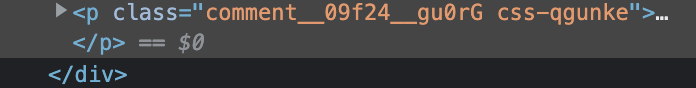

In [ ]:
r = requests.get('https://www.yelp.com/biz/red-white-ramen-newbury-st-boston-4?osq=buddha+ramen')
soup = BeautifulSoup(r.text, 'html.parser')
# recall we find each review in the web class comment
regex = re.compile('.*comment.*')
# find_all looks for p in html then regex -> looks for comment
results = soup.find_all('p', {'class': regex})

# list comprehension find just the comment review
reviews = [result.text for result in results]

# Load in dataframe then calculate Sentiment

why dataframe? easy to process data 

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.array(reviews), columns=['review'])

In [ ]:
df.shape

(10, 2)

In [ ]:
# locate a single comment
df['review'].iloc[0]

'This is the best ramen I have ever had!!! \xa0I never thought I would ever have a robust bowl of ramen again now that I am vegan because I have been let down so many times by other restaurants! The avocado and Mac and cheese are also AMAZING!!! \xa0Red White is now my favorite restaurant in all of Massachusetts! We will be back many times. \xa0Thank you for what you do!'

We will write a quick function so we can calculate sentiment of the reviews

In [ ]:
def cal_sentiment(review):
  tokens = tokenizer.encode(review, return_tensors=('pt'))
  result = model(tokens)
  return int(torch.argmax(result.logits)) + 1

In [ ]:
# we can use lambda function so we can pass through the whole dataframe and calculate the sentiment
# x[:512] -> grabbing only first 512 tokens(may change result of sentiment score). Tokenizer has a limit on token. 
df['sentiment'] = df['review'].apply(lambda x: cal_sentiment(x[:512]))

In [ ]:
df

,review,sentiment
0,This is the best ramen I have ever had!!! I n...,5
1,Fantastic food and friendly staff. Love their ...,5
2,one of my favorite restaurants in boston!every...,5
3,I love Ramen and searched Yelp and places on N...,3
4,This is hands down the best vegan ramen I have...,5
5,I'm gonna say it-- this place is better than S...,4
6,My friends and I were passing by during a shop...,4
7,This is a hip kind of spot for the kiddies and...,5
8,I was on a vegetarian ramen kick so when I saw...,2
9,I found the ramen here to be so-so. More gimmi...,3
